In [1]:
# Exercise_2
# main simple regression WHO data
# TODO**
# Names of group members: Fabian Bloch and Christopher Mahn
# Date: April 24th, 2023
# TODO**

In [2]:
#%% Load modules
import numpy as np
import pandas as pd
# import csv

# torch modules
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# plot module
import matplotlib.pyplot as plt

# module for interoperable file-operations
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f'Path of this exercise: {path}')

Path of this exercise: /hdd/repository/hcu-ma-gmt-big-data-analysis/data/ex2


In [3]:
# %% CUDA for PyTorch
# Right at the beginning: check if a cuda compatible GPU is available in your computer. 
# If so, set device = cuda:0 which means that later all calculations will be performed on the graphics card. 
# If no GPU is available, the calculations will run on the CPU, which is also absolutely sufficient for the examples in these exercises.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# cudnn.benchmark = True
if(use_cuda):
    print(f'Found: {torch.cuda.get_device_name()}')
if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

Found: NVIDIA GeForce RTX 3080 Ti
Device: cuda -- Number of devices: 1


In [4]:
# Mounting Google Drive locally 
# from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
# drive.mount('/content/drive')
# you can also choose one of the other options to load data
# therefore see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

In [5]:
# %% read data
# path to WHO data
data_path = os.path.join(path, 'data/life-expectancy-who/Life Expectancy Data.csv')

# read csv sheet with pandas
df = pd.read_csv(data_path)

# drop each row where is nan data
df = df.dropna()
# drop each row where is not at least 21 not nan data
# df = df.dropna(thresh=21) # there are many nan in row 4 12 14, which can cause errors

# get numpy out of pandas dataframe
data = df.values
# data=df.to_numpy()

# get column names to see, which columns we have to extract as x and y
column_names = np.array(df.columns[:], dtype=np.str_)

# TODO**
print(f'Dimension of the dataset: {np.shape(data)}')
# TODO**

Dimension of the dataset: (1649, 22)


In [6]:
# %% split in X and Y
# extract any feature you want as X 
# extract target values as Y
# TODO**
x = np.array(data[:,10], dtype=np.float32)
y = np.array(data[:,3], dtype=np.float32)
# TODO**
print('x shape:', x.shape)
print('y shape:', y.shape)
print(f'x_1 = {x[0]:.1f} = 19.1')
print(f'y_1 = {y[0]:.1f} = 65.0')

x shape: (1649,)
y shape: (1649,)
x_1 = 19.1 = 19.1
y_1 = 65.0 = 65.0


In [7]:
# %% normalize X and Y between (0,1). If multiple features in X are selected, each feature is normalized individually
scale_x = np.max(x, axis=0)
scale_y = np.max(y, axis=0)
x = x/scale_x
y = y/scale_y
print('Scale_x:',scale_x)
print('Scale_y:',scale_y)

Scale_x: 77.1
Scale_y: 89.0


In [8]:
# %% convert to torch tensors
# if tensors have only one dimension, an artificial dimension is created with unsqueeze (e.g. [10]->[10,1], so 1D->2D)
Y = torch.from_numpy(y)
Y = Y.float()
if len(Y.shape)==1:
    Y = Y.unsqueeze(dim=1)

X = torch.from_numpy(x)
X = X.float()
if len(X.shape)==1:
    X = X.unsqueeze(dim=1)

In [9]:
# %% Split dataset in training, validation and test tensors
# TODO**
prop_train = 0.5
prop_val = 0.25
prop_test = 0.25
# TODO**

sample_num = {'all': X.shape[0], 
              'train': round(prop_train*X.shape[0]),
              'val': round(prop_val*X.shape[0]),
              'test': round(prop_test*X.shape[0])}

# idx shuffle
idx = np.random.choice(sample_num['all'], sample_num['all'], replace=False)
# assign idx to each sample
sample_idx = {'all': idx[:], 
              'train': idx[0:sample_num['train']],
              'val': idx[sample_num['train']:sample_num['train']+sample_num['val']],
              'test': idx[sample_num['train']+sample_num['val']:]}

# Create train data
X_train = X[sample_idx['train']]
Y_train = Y[sample_idx['train']]

# Create validation data
X_val = X[sample_idx['val']]
Y_val = Y[sample_idx['val']]

# Create test data
X_test = X[sample_idx['test']]
Y_test = Y[sample_idx['test']]


# %% Show data point
print('Input of first ten train Sample:', X_train[0:10])
print('Target of first ten train Sample:', Y_train[0:10])

Input of first ten train Sample: tensor([[0.1012],
        [0.8392],
        [0.7704],
        [0.7652],
        [0.2335],
        [0.8366],
        [0.0324],
        [0.5966],
        [0.7147],
        [0.7769]])
Target of first ten train Sample: tensor([[0.8146],
        [0.9157],
        [0.9135],
        [0.8640],
        [0.6079],
        [0.8449],
        [0.6348],
        [0.8067],
        [0.8326],
        [0.8202]])


In [10]:
#%% class of neural network 'RegressNet'
# set up layer and architecture of network in constructor __init__
# define operations on layer in forward pass method
class RegressNet(nn.Module):
    
    def __init__(self, inputSize, outputSize):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(inputSize, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, outputSize)
    
    def forward(self, x):
        # max pooling over (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
#%% Specify network hyperparameter and create instance of RegressNet
# TODO**        
inputDim = 1
outputDim = 1

# Create instance of RegressNet
net = RegressNet(inputDim, outputDim)
# TODO**
print(net)

RegressNet(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
print(torch.version.cuda)

#%% Send tensors and networks to GPU (if you have one which supports cuda) for faster computations
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_val, Y_val = X_val.to(device), Y_val.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# The network itself must also be sent to the GPU. Either you write net = RegressNet() and then later net.to(device) or directly net = RegressNet().to(device)
# The latter option may have the advantage that the instance net is created directly on the GPU, whereas in variant 1 it must first be sent to the GPU.
if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device)

11.7


RegressNet(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
#%% Specify hyperparameter
# hyperparemter: num_epoch, num_lr, loss_func, optimizer
# how many epochs do we want to train?
# TODO** 
num_epoch = 10000
learn_rate = 1e-3
# TODO**
# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)

In [14]:
#%% Loss before training
# Compute loss of test data before training the network (with random weights)
Y_pred_train_before = net(X_train)
loss_train_before = loss_func(Y_pred_train_before, Y_train)
Y_pred_val_before = net(X_val)
loss_val_before = loss_func(Y_pred_val_before, Y_val)
Y_pred_test_before = net(X_test)
loss_test_before = loss_func(Y_pred_test_before, Y_test)

Train Epoch: 1/10000 (0%)	train_Loss: 0.768727	val_Loss: 0.637763
Train Epoch: 2/10000 (0%)	train_Loss: 0.637459	val_Loss: 0.521257
Train Epoch: 3/10000 (0%)	train_Loss: 0.521027	val_Loss: 0.421367
Train Epoch: 4/10000 (0%)	train_Loss: 0.421414	val_Loss: 0.341460
Train Epoch: 5/10000 (0%)	train_Loss: 0.341874	val_Loss: 0.277057
Train Epoch: 6/10000 (0%)	train_Loss: 0.277517	val_Loss: 0.222436
Train Epoch: 7/10000 (0%)	train_Loss: 0.222891	val_Loss: 0.176282
Train Epoch: 8/10000 (0%)	train_Loss: 0.176837	val_Loss: 0.137101
Train Epoch: 9/10000 (0%)	train_Loss: 0.137623	val_Loss: 0.103785
Train Epoch: 10/10000 (0%)	train_Loss: 0.104288	val_Loss: 0.076910
Train Epoch: 11/10000 (0%)	train_Loss: 0.077390	val_Loss: 0.056300
Train Epoch: 12/10000 (0%)	train_Loss: 0.056757	val_Loss: 0.039924
Train Epoch: 13/10000 (0%)	train_Loss: 0.040357	val_Loss: 0.027437
Train Epoch: 14/10000 (0%)	train_Loss: 0.027820	val_Loss: 0.018631
Train Epoch: 15/10000 (0%)	train_Loss: 0.018963	val_Loss: 0.012611
Trai

Train Epoch: 137/10000 (1%)	train_Loss: 0.006132	val_Loss: 0.006256
Train Epoch: 138/10000 (1%)	train_Loss: 0.006127	val_Loss: 0.006252
Train Epoch: 139/10000 (1%)	train_Loss: 0.006123	val_Loss: 0.006249
Train Epoch: 140/10000 (1%)	train_Loss: 0.006118	val_Loss: 0.006245
Train Epoch: 141/10000 (1%)	train_Loss: 0.006114	val_Loss: 0.006242
Train Epoch: 142/10000 (1%)	train_Loss: 0.006109	val_Loss: 0.006238
Train Epoch: 143/10000 (1%)	train_Loss: 0.006105	val_Loss: 0.006235
Train Epoch: 144/10000 (1%)	train_Loss: 0.006100	val_Loss: 0.006231
Train Epoch: 145/10000 (1%)	train_Loss: 0.006096	val_Loss: 0.006227
Train Epoch: 146/10000 (1%)	train_Loss: 0.006091	val_Loss: 0.006223
Train Epoch: 147/10000 (1%)	train_Loss: 0.006087	val_Loss: 0.006219
Train Epoch: 148/10000 (1%)	train_Loss: 0.006082	val_Loss: 0.006215
Train Epoch: 149/10000 (1%)	train_Loss: 0.006078	val_Loss: 0.006211
Train Epoch: 150/10000 (1%)	train_Loss: 0.006073	val_Loss: 0.006207
Train Epoch: 151/10000 (2%)	train_Loss: 0.006069

Train Epoch: 298/10000 (3%)	train_Loss: 0.005594	val_Loss: 0.005771
Train Epoch: 299/10000 (3%)	train_Loss: 0.005592	val_Loss: 0.005769
Train Epoch: 300/10000 (3%)	train_Loss: 0.005590	val_Loss: 0.005767
Train Epoch: 301/10000 (3%)	train_Loss: 0.005588	val_Loss: 0.005765
Train Epoch: 302/10000 (3%)	train_Loss: 0.005586	val_Loss: 0.005763
Train Epoch: 303/10000 (3%)	train_Loss: 0.005584	val_Loss: 0.005761
Train Epoch: 304/10000 (3%)	train_Loss: 0.005581	val_Loss: 0.005759
Train Epoch: 305/10000 (3%)	train_Loss: 0.005579	val_Loss: 0.005757
Train Epoch: 306/10000 (3%)	train_Loss: 0.005577	val_Loss: 0.005756
Train Epoch: 307/10000 (3%)	train_Loss: 0.005575	val_Loss: 0.005754
Train Epoch: 308/10000 (3%)	train_Loss: 0.005573	val_Loss: 0.005752
Train Epoch: 309/10000 (3%)	train_Loss: 0.005571	val_Loss: 0.005750
Train Epoch: 310/10000 (3%)	train_Loss: 0.005569	val_Loss: 0.005748
Train Epoch: 311/10000 (3%)	train_Loss: 0.005567	val_Loss: 0.005746
Train Epoch: 312/10000 (3%)	train_Loss: 0.005565

Train Epoch: 454/10000 (5%)	train_Loss: 0.005314	val_Loss: 0.005536
Train Epoch: 455/10000 (5%)	train_Loss: 0.005312	val_Loss: 0.005535
Train Epoch: 456/10000 (5%)	train_Loss: 0.005310	val_Loss: 0.005534
Train Epoch: 457/10000 (5%)	train_Loss: 0.005309	val_Loss: 0.005532
Train Epoch: 458/10000 (5%)	train_Loss: 0.005307	val_Loss: 0.005531
Train Epoch: 459/10000 (5%)	train_Loss: 0.005305	val_Loss: 0.005529
Train Epoch: 460/10000 (5%)	train_Loss: 0.005304	val_Loss: 0.005528
Train Epoch: 461/10000 (5%)	train_Loss: 0.005302	val_Loss: 0.005527
Train Epoch: 462/10000 (5%)	train_Loss: 0.005300	val_Loss: 0.005526
Train Epoch: 463/10000 (5%)	train_Loss: 0.005299	val_Loss: 0.005524
Train Epoch: 464/10000 (5%)	train_Loss: 0.005297	val_Loss: 0.005523
Train Epoch: 465/10000 (5%)	train_Loss: 0.005295	val_Loss: 0.005522
Train Epoch: 466/10000 (5%)	train_Loss: 0.005294	val_Loss: 0.005520
Train Epoch: 467/10000 (5%)	train_Loss: 0.005292	val_Loss: 0.005518
Train Epoch: 468/10000 (5%)	train_Loss: 0.005290

Train Epoch: 595/10000 (6%)	train_Loss: 0.005073	val_Loss: 0.005332
Train Epoch: 596/10000 (6%)	train_Loss: 0.005072	val_Loss: 0.005330
Train Epoch: 597/10000 (6%)	train_Loss: 0.005070	val_Loss: 0.005329
Train Epoch: 598/10000 (6%)	train_Loss: 0.005068	val_Loss: 0.005327
Train Epoch: 599/10000 (6%)	train_Loss: 0.005067	val_Loss: 0.005326
Train Epoch: 600/10000 (6%)	train_Loss: 0.005065	val_Loss: 0.005325
Train Epoch: 601/10000 (6%)	train_Loss: 0.005063	val_Loss: 0.005323
Train Epoch: 602/10000 (6%)	train_Loss: 0.005062	val_Loss: 0.005321
Train Epoch: 603/10000 (6%)	train_Loss: 0.005060	val_Loss: 0.005320
Train Epoch: 604/10000 (6%)	train_Loss: 0.005058	val_Loss: 0.005318
Train Epoch: 605/10000 (6%)	train_Loss: 0.005057	val_Loss: 0.005317
Train Epoch: 606/10000 (6%)	train_Loss: 0.005055	val_Loss: 0.005315
Train Epoch: 607/10000 (6%)	train_Loss: 0.005053	val_Loss: 0.005314
Train Epoch: 608/10000 (6%)	train_Loss: 0.005052	val_Loss: 0.005312
Train Epoch: 609/10000 (6%)	train_Loss: 0.005050

Train Epoch: 749/10000 (7%)	train_Loss: 0.004833	val_Loss: 0.005121
Train Epoch: 750/10000 (7%)	train_Loss: 0.004832	val_Loss: 0.005120
Train Epoch: 751/10000 (8%)	train_Loss: 0.004831	val_Loss: 0.005119
Train Epoch: 752/10000 (8%)	train_Loss: 0.004829	val_Loss: 0.005118
Train Epoch: 753/10000 (8%)	train_Loss: 0.004828	val_Loss: 0.005117
Train Epoch: 754/10000 (8%)	train_Loss: 0.004826	val_Loss: 0.005116
Train Epoch: 755/10000 (8%)	train_Loss: 0.004825	val_Loss: 0.005114
Train Epoch: 756/10000 (8%)	train_Loss: 0.004824	val_Loss: 0.005113
Train Epoch: 757/10000 (8%)	train_Loss: 0.004822	val_Loss: 0.005112
Train Epoch: 758/10000 (8%)	train_Loss: 0.004821	val_Loss: 0.005111
Train Epoch: 759/10000 (8%)	train_Loss: 0.004819	val_Loss: 0.005110
Train Epoch: 760/10000 (8%)	train_Loss: 0.004818	val_Loss: 0.005109
Train Epoch: 761/10000 (8%)	train_Loss: 0.004817	val_Loss: 0.005107
Train Epoch: 762/10000 (8%)	train_Loss: 0.004815	val_Loss: 0.005106
Train Epoch: 763/10000 (8%)	train_Loss: 0.004814

Train Epoch: 902/10000 (9%)	train_Loss: 0.004636	val_Loss: 0.004955
Train Epoch: 903/10000 (9%)	train_Loss: 0.004635	val_Loss: 0.004954
Train Epoch: 904/10000 (9%)	train_Loss: 0.004634	val_Loss: 0.004953
Train Epoch: 905/10000 (9%)	train_Loss: 0.004633	val_Loss: 0.004952
Train Epoch: 906/10000 (9%)	train_Loss: 0.004632	val_Loss: 0.004951
Train Epoch: 907/10000 (9%)	train_Loss: 0.004631	val_Loss: 0.004950
Train Epoch: 908/10000 (9%)	train_Loss: 0.004630	val_Loss: 0.004949
Train Epoch: 909/10000 (9%)	train_Loss: 0.004629	val_Loss: 0.004948
Train Epoch: 910/10000 (9%)	train_Loss: 0.004627	val_Loss: 0.004947
Train Epoch: 911/10000 (9%)	train_Loss: 0.004626	val_Loss: 0.004946
Train Epoch: 912/10000 (9%)	train_Loss: 0.004625	val_Loss: 0.004945
Train Epoch: 913/10000 (9%)	train_Loss: 0.004624	val_Loss: 0.004945
Train Epoch: 914/10000 (9%)	train_Loss: 0.004623	val_Loss: 0.004944
Train Epoch: 915/10000 (9%)	train_Loss: 0.004622	val_Loss: 0.004943
Train Epoch: 916/10000 (9%)	train_Loss: 0.004621

Train Epoch: 1042/10000 (10%)	train_Loss: 0.004514	val_Loss: 0.004831
Train Epoch: 1043/10000 (10%)	train_Loss: 0.004514	val_Loss: 0.004830
Train Epoch: 1044/10000 (10%)	train_Loss: 0.004513	val_Loss: 0.004830
Train Epoch: 1045/10000 (10%)	train_Loss: 0.004512	val_Loss: 0.004829
Train Epoch: 1046/10000 (10%)	train_Loss: 0.004511	val_Loss: 0.004828
Train Epoch: 1047/10000 (10%)	train_Loss: 0.004511	val_Loss: 0.004827
Train Epoch: 1048/10000 (10%)	train_Loss: 0.004510	val_Loss: 0.004826
Train Epoch: 1049/10000 (10%)	train_Loss: 0.004509	val_Loss: 0.004825
Train Epoch: 1050/10000 (10%)	train_Loss: 0.004509	val_Loss: 0.004824
Train Epoch: 1051/10000 (10%)	train_Loss: 0.004508	val_Loss: 0.004824
Train Epoch: 1052/10000 (11%)	train_Loss: 0.004507	val_Loss: 0.004823
Train Epoch: 1053/10000 (11%)	train_Loss: 0.004506	val_Loss: 0.004822
Train Epoch: 1054/10000 (11%)	train_Loss: 0.004506	val_Loss: 0.004821
Train Epoch: 1055/10000 (11%)	train_Loss: 0.004505	val_Loss: 0.004820
Train Epoch: 1056/10

Train Epoch: 1173/10000 (12%)	train_Loss: 0.004438	val_Loss: 0.004746
Train Epoch: 1174/10000 (12%)	train_Loss: 0.004438	val_Loss: 0.004746
Train Epoch: 1175/10000 (12%)	train_Loss: 0.004437	val_Loss: 0.004745
Train Epoch: 1176/10000 (12%)	train_Loss: 0.004437	val_Loss: 0.004745
Train Epoch: 1177/10000 (12%)	train_Loss: 0.004436	val_Loss: 0.004744
Train Epoch: 1178/10000 (12%)	train_Loss: 0.004436	val_Loss: 0.004744
Train Epoch: 1179/10000 (12%)	train_Loss: 0.004436	val_Loss: 0.004744
Train Epoch: 1180/10000 (12%)	train_Loss: 0.004435	val_Loss: 0.004743
Train Epoch: 1181/10000 (12%)	train_Loss: 0.004434	val_Loss: 0.004742
Train Epoch: 1182/10000 (12%)	train_Loss: 0.004434	val_Loss: 0.004742
Train Epoch: 1183/10000 (12%)	train_Loss: 0.004434	val_Loss: 0.004741
Train Epoch: 1184/10000 (12%)	train_Loss: 0.004433	val_Loss: 0.004741
Train Epoch: 1185/10000 (12%)	train_Loss: 0.004433	val_Loss: 0.004741
Train Epoch: 1186/10000 (12%)	train_Loss: 0.004432	val_Loss: 0.004741
Train Epoch: 1187/10

Train Epoch: 1317/10000 (13%)	train_Loss: 0.004386	val_Loss: 0.004697
Train Epoch: 1318/10000 (13%)	train_Loss: 0.004386	val_Loss: 0.004697
Train Epoch: 1319/10000 (13%)	train_Loss: 0.004385	val_Loss: 0.004696
Train Epoch: 1320/10000 (13%)	train_Loss: 0.004385	val_Loss: 0.004696
Train Epoch: 1321/10000 (13%)	train_Loss: 0.004385	val_Loss: 0.004696
Train Epoch: 1322/10000 (13%)	train_Loss: 0.004385	val_Loss: 0.004696
Train Epoch: 1323/10000 (13%)	train_Loss: 0.004384	val_Loss: 0.004695
Train Epoch: 1324/10000 (13%)	train_Loss: 0.004384	val_Loss: 0.004695
Train Epoch: 1325/10000 (13%)	train_Loss: 0.004384	val_Loss: 0.004695
Train Epoch: 1326/10000 (13%)	train_Loss: 0.004384	val_Loss: 0.004695
Train Epoch: 1327/10000 (13%)	train_Loss: 0.004383	val_Loss: 0.004695
Train Epoch: 1328/10000 (13%)	train_Loss: 0.004383	val_Loss: 0.004694
Train Epoch: 1329/10000 (13%)	train_Loss: 0.004383	val_Loss: 0.004694
Train Epoch: 1330/10000 (13%)	train_Loss: 0.004383	val_Loss: 0.004694
Train Epoch: 1331/10

Train Epoch: 1461/10000 (15%)	train_Loss: 0.004354	val_Loss: 0.004668
Train Epoch: 1462/10000 (15%)	train_Loss: 0.004354	val_Loss: 0.004667
Train Epoch: 1463/10000 (15%)	train_Loss: 0.004354	val_Loss: 0.004667
Train Epoch: 1464/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004667
Train Epoch: 1465/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004667
Train Epoch: 1466/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004667
Train Epoch: 1467/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004667
Train Epoch: 1468/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004666
Train Epoch: 1469/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004666
Train Epoch: 1470/10000 (15%)	train_Loss: 0.004353	val_Loss: 0.004666
Train Epoch: 1471/10000 (15%)	train_Loss: 0.004352	val_Loss: 0.004666
Train Epoch: 1472/10000 (15%)	train_Loss: 0.004352	val_Loss: 0.004666
Train Epoch: 1473/10000 (15%)	train_Loss: 0.004352	val_Loss: 0.004665
Train Epoch: 1474/10000 (15%)	train_Loss: 0.004352	val_Loss: 0.004665
Train Epoch: 1475/10

Train Epoch: 1598/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1599/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1600/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1601/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1602/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1603/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1604/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1605/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1606/10000 (16%)	train_Loss: 0.004336	val_Loss: 0.004648
Train Epoch: 1607/10000 (16%)	train_Loss: 0.004335	val_Loss: 0.004648
Train Epoch: 1608/10000 (16%)	train_Loss: 0.004335	val_Loss: 0.004647
Train Epoch: 1609/10000 (16%)	train_Loss: 0.004335	val_Loss: 0.004647
Train Epoch: 1610/10000 (16%)	train_Loss: 0.004335	val_Loss: 0.004647
Train Epoch: 1611/10000 (16%)	train_Loss: 0.004335	val_Loss: 0.004647
Train Epoch: 1612/10

Train Epoch: 1725/10000 (17%)	train_Loss: 0.004325	val_Loss: 0.004637
Train Epoch: 1726/10000 (17%)	train_Loss: 0.004325	val_Loss: 0.004637
Train Epoch: 1727/10000 (17%)	train_Loss: 0.004325	val_Loss: 0.004637
Train Epoch: 1728/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1729/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1730/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1731/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1732/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1733/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1734/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1735/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1736/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1737/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1738/10000 (17%)	train_Loss: 0.004324	val_Loss: 0.004637
Train Epoch: 1739/10

Train Epoch: 1846/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1847/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1848/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1849/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1850/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1851/10000 (18%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1852/10000 (19%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1853/10000 (19%)	train_Loss: 0.004317	val_Loss: 0.004632
Train Epoch: 1854/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1855/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1856/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1857/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1858/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1859/10000 (19%)	train_Loss: 0.004316	val_Loss: 0.004632
Train Epoch: 1860/10

Train Epoch: 1984/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004629
Train Epoch: 1985/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004629
Train Epoch: 1986/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004629
Train Epoch: 1987/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004629
Train Epoch: 1988/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004628
Train Epoch: 1989/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004628
Train Epoch: 1990/10000 (20%)	train_Loss: 0.004310	val_Loss: 0.004628
Train Epoch: 1991/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1992/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1993/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1994/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1995/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1996/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1997/10000 (20%)	train_Loss: 0.004309	val_Loss: 0.004628
Train Epoch: 1998/10

Train Epoch: 2118/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004628
Train Epoch: 2119/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004628
Train Epoch: 2120/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004628
Train Epoch: 2121/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2122/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2123/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2124/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2125/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2126/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2127/10000 (21%)	train_Loss: 0.004305	val_Loss: 0.004627
Train Epoch: 2128/10000 (21%)	train_Loss: 0.004304	val_Loss: 0.004627
Train Epoch: 2129/10000 (21%)	train_Loss: 0.004304	val_Loss: 0.004627
Train Epoch: 2130/10000 (21%)	train_Loss: 0.004304	val_Loss: 0.004627
Train Epoch: 2131/10000 (21%)	train_Loss: 0.004304	val_Loss: 0.004627
Train Epoch: 2132/10

Train Epoch: 2247/10000 (22%)	train_Loss: 0.004302	val_Loss: 0.004628
Train Epoch: 2248/10000 (22%)	train_Loss: 0.004302	val_Loss: 0.004628
Train Epoch: 2249/10000 (22%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2250/10000 (22%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2251/10000 (22%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2252/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2253/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2254/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2255/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2256/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2257/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2258/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2259/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2260/10000 (23%)	train_Loss: 0.004301	val_Loss: 0.004628
Train Epoch: 2261/10

Train Epoch: 2370/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2371/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004629
Train Epoch: 2372/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2373/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2374/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2375/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2376/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2377/10000 (24%)	train_Loss: 0.004300	val_Loss: 0.004628
Train Epoch: 2378/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2379/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2380/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2381/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2382/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2383/10000 (24%)	train_Loss: 0.004299	val_Loss: 0.004628
Train Epoch: 2384/10

Train Epoch: 2506/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2507/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2508/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2509/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2510/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2511/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2512/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2513/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2514/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2515/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2516/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2517/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2518/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2519/10000 (25%)	train_Loss: 0.004298	val_Loss: 0.004627
Train Epoch: 2520/10

Train Epoch: 2639/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2640/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2641/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2642/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2643/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2644/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2645/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2646/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2647/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2648/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2649/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2650/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2651/10000 (26%)	train_Loss: 0.004297	val_Loss: 0.004629
Train Epoch: 2652/10000 (27%)	train_Loss: 0.004297	val_Loss: 0.004628
Train Epoch: 2653/10

Train Epoch: 2766/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2767/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2768/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2769/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2770/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2771/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2772/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004630
Train Epoch: 2773/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004630
Train Epoch: 2774/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004630
Train Epoch: 2775/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004630
Train Epoch: 2776/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2777/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2778/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2779/10000 (28%)	train_Loss: 0.004296	val_Loss: 0.004631
Train Epoch: 2780/10

Train Epoch: 2889/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2890/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2891/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2892/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2893/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2894/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2895/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2896/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2897/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004633
Train Epoch: 2898/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004633
Train Epoch: 2899/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004633
Train Epoch: 2900/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004633
Train Epoch: 2901/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2902/10000 (29%)	train_Loss: 0.004296	val_Loss: 0.004632
Train Epoch: 2903/10

Train Epoch: 3008/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3009/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3010/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3011/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3012/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3013/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3014/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3015/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3016/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3017/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3018/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3019/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3020/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3021/10000 (30%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3022/10

Train Epoch: 3141/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3142/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3143/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3144/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3145/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3146/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3147/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3148/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3149/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3150/10000 (31%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3151/10000 (32%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3152/10000 (32%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3153/10000 (32%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3154/10000 (32%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3155/10

Train Epoch: 3269/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3270/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3271/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3272/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3273/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3274/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3275/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3276/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3277/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3278/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3279/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3280/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3281/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3282/10000 (33%)	train_Loss: 0.004295	val_Loss: 0.004633
Train Epoch: 3283/10

Train Epoch: 3393/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3394/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3395/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3396/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3397/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3398/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3399/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3400/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3401/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3402/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3403/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3404/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3405/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3406/10000 (34%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3407/10

Train Epoch: 3513/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3514/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3515/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3516/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3517/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3518/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3519/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3520/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3521/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3522/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3523/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3524/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3525/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3526/10000 (35%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3527/10

Train Epoch: 3633/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3634/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3635/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3636/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3637/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004634
Train Epoch: 3638/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3639/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3640/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3641/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3642/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3643/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3644/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3645/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004635
Train Epoch: 3646/10000 (36%)	train_Loss: 0.004295	val_Loss: 0.004636
Train Epoch: 3647/10

Train Epoch: 3751/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 3752/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 3753/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 3754/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3755/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3756/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3757/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3758/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3759/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 3760/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3761/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3762/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3763/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 3764/10000 (38%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3765/10

Train Epoch: 3876/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3877/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 3878/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 3879/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3880/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3881/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3882/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 3883/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 3884/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3885/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3886/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3887/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 3888/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3889/10000 (39%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 3890/10

Train Epoch: 4001/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4002/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4003/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4004/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4005/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4006/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4007/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4008/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4009/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4010/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4011/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4012/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4013/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4014/10000 (40%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4015/10

Train Epoch: 4119/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4120/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4121/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4122/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4123/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4124/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 4125/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4126/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4127/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4128/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4129/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 4130/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 4131/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4132/10000 (41%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4133/10

Train Epoch: 4247/10000 (42%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4248/10000 (42%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4249/10000 (42%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4250/10000 (42%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4251/10000 (42%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4252/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4253/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4254/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4255/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4256/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4257/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4258/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4259/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4260/10000 (43%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4261/10

Train Epoch: 4371/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4372/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4373/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4374/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004633
Train Epoch: 4375/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004633
Train Epoch: 4376/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4377/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4378/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4379/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4380/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4381/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4382/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004636
Train Epoch: 4383/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4384/10000 (44%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4385/10

Train Epoch: 4492/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4493/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4494/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4495/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4496/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4497/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4498/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4499/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4500/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4501/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4502/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4503/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4504/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4505/10000 (45%)	train_Loss: 0.004294	val_Loss: 0.004633
Train Epoch: 4506/10

Train Epoch: 4612/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4613/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4614/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4615/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4616/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4617/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4618/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4619/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4620/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4621/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4622/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4623/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4624/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4625/10000 (46%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4626/10

Train Epoch: 4730/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4731/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4732/10000 (47%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4733/10000 (47%)	train_Loss: 0.004294	val_Loss: 0.004634
Train Epoch: 4734/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4735/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4736/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4737/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4738/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4739/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4740/10000 (47%)	train_Loss: 0.004294	val_Loss: 0.004635
Train Epoch: 4741/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4742/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4743/10000 (47%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4744/10

Train Epoch: 4850/10000 (48%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 4851/10000 (48%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 4852/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4853/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4854/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4855/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4856/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4857/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4858/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4859/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4860/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4861/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4862/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4863/10000 (49%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4864/10

Train Epoch: 4969/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4970/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4971/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4972/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4973/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4974/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4975/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4976/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4977/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4978/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 4979/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4980/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4981/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 4982/10000 (50%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 4983/10

Train Epoch: 5095/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5096/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5097/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5098/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5099/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5100/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5101/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5102/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5103/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5104/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5105/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5106/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5107/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5108/10000 (51%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5109/10

Train Epoch: 5213/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5214/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5215/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5216/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5217/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5218/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5219/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5220/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5221/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5222/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5223/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5224/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5225/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5226/10000 (52%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5227/10

Train Epoch: 5332/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5333/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5334/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5335/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5336/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5337/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5338/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5339/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5340/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5341/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5342/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5343/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5344/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5345/10000 (53%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5346/10

Train Epoch: 5453/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5454/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5455/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5456/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5457/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5458/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004634
Train Epoch: 5459/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5460/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5461/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004631
Train Epoch: 5462/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5463/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5464/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5465/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5466/10000 (55%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5467/10

Train Epoch: 5572/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5573/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5574/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5575/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5576/10000 (56%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5577/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5578/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5579/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5580/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004632
Train Epoch: 5581/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5582/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004633
Train Epoch: 5583/10000 (56%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5584/10000 (56%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 5585/10000 (56%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 5586/10

Train Epoch: 5698/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5699/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5700/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5701/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5702/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5703/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5704/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5705/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5706/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5707/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5708/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5709/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5710/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5711/10000 (57%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5712/10

Train Epoch: 5821/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5822/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5823/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5824/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5825/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 5826/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5827/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5828/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5829/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5830/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5831/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5832/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5833/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5834/10000 (58%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5835/10

Train Epoch: 5942/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5943/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5944/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5945/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5946/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5947/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5948/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5949/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5950/10000 (59%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5951/10000 (60%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5952/10000 (60%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5953/10000 (60%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5954/10000 (60%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 5955/10000 (60%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 5956/10

Train Epoch: 6068/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6069/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6070/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6071/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6072/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6073/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6074/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6075/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6076/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6077/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6078/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6079/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6080/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6081/10000 (61%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6082/10

Train Epoch: 6187/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6188/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6189/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6190/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6191/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6192/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6193/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6194/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6195/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6196/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6197/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6198/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6199/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6200/10000 (62%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6201/10

Train Epoch: 6306/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6307/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6308/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6309/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6310/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6311/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6312/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6313/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6314/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6315/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6316/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6317/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6318/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6319/10000 (63%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6320/10

Train Epoch: 6428/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6429/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6430/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6431/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6432/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6433/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6434/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6435/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6436/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6437/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6438/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6439/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6440/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6441/10000 (64%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6442/10

Train Epoch: 6549/10000 (65%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6550/10000 (65%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6551/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6552/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6553/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6554/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6555/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6556/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6557/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6558/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6559/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6560/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6561/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6562/10000 (66%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6563/10

Train Epoch: 6668/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 6669/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6670/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6671/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 6672/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6673/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 6674/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6675/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 6676/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6677/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6678/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6679/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6680/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6681/10000 (67%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 6682/10

Train Epoch: 6793/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6794/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 6795/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6796/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 6797/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 6798/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6799/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 6800/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 6801/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6802/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004636
Train Epoch: 6803/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6804/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 6805/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 6806/10000 (68%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6807/10

Train Epoch: 6917/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6918/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6919/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 6920/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6921/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6922/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6923/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6924/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6925/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6926/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6927/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 6928/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6929/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 6930/10000 (69%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 6931/10

Train Epoch: 7039/10000 (70%)	train_Loss: 0.004293	val_Loss: 0.004639
Train Epoch: 7040/10000 (70%)	train_Loss: 0.004293	val_Loss: 0.004628
Train Epoch: 7041/10000 (70%)	train_Loss: 0.004294	val_Loss: 0.004641
Train Epoch: 7042/10000 (70%)	train_Loss: 0.004294	val_Loss: 0.004627
Train Epoch: 7043/10000 (70%)	train_Loss: 0.004295	val_Loss: 0.004645
Train Epoch: 7044/10000 (70%)	train_Loss: 0.004296	val_Loss: 0.004627
Train Epoch: 7045/10000 (70%)	train_Loss: 0.004297	val_Loss: 0.004649
Train Epoch: 7046/10000 (70%)	train_Loss: 0.004298	val_Loss: 0.004626
Train Epoch: 7047/10000 (70%)	train_Loss: 0.004299	val_Loss: 0.004653
Train Epoch: 7048/10000 (70%)	train_Loss: 0.004301	val_Loss: 0.004627
Train Epoch: 7049/10000 (70%)	train_Loss: 0.004302	val_Loss: 0.004657
Train Epoch: 7050/10000 (70%)	train_Loss: 0.004303	val_Loss: 0.004628
Train Epoch: 7051/10000 (70%)	train_Loss: 0.004303	val_Loss: 0.004656
Train Epoch: 7052/10000 (71%)	train_Loss: 0.004302	val_Loss: 0.004626
Train Epoch: 7053/10

Train Epoch: 7161/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7162/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7163/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7164/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7165/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7166/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7167/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7168/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7169/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7170/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7171/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7172/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7173/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7174/10000 (72%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7175/10

Train Epoch: 7279/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7280/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7281/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7282/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7283/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7284/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7285/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7286/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7287/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7288/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7289/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7290/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7291/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7292/10000 (73%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7293/10

Train Epoch: 7401/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7402/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7403/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7404/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7405/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004636
Train Epoch: 7406/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7407/10000 (74%)	train_Loss: 0.004292	val_Loss: 0.004638
Train Epoch: 7408/10000 (74%)	train_Loss: 0.004293	val_Loss: 0.004628
Train Epoch: 7409/10000 (74%)	train_Loss: 0.004293	val_Loss: 0.004640
Train Epoch: 7410/10000 (74%)	train_Loss: 0.004294	val_Loss: 0.004626
Train Epoch: 7411/10000 (74%)	train_Loss: 0.004294	val_Loss: 0.004644
Train Epoch: 7412/10000 (74%)	train_Loss: 0.004296	val_Loss: 0.004626
Train Epoch: 7413/10000 (74%)	train_Loss: 0.004297	val_Loss: 0.004651
Train Epoch: 7414/10000 (74%)	train_Loss: 0.004299	val_Loss: 0.004627
Train Epoch: 7415/10

Train Epoch: 7523/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7524/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7525/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7526/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 7527/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7528/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 7529/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7530/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004637
Train Epoch: 7531/10000 (75%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7532/10000 (75%)	train_Loss: 0.004293	val_Loss: 0.004639
Train Epoch: 7533/10000 (75%)	train_Loss: 0.004293	val_Loss: 0.004627
Train Epoch: 7534/10000 (75%)	train_Loss: 0.004294	val_Loss: 0.004642
Train Epoch: 7535/10000 (75%)	train_Loss: 0.004295	val_Loss: 0.004627
Train Epoch: 7536/10000 (75%)	train_Loss: 0.004296	val_Loss: 0.004647
Train Epoch: 7537/10

Train Epoch: 7641/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7642/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7643/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7644/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 7645/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7646/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 7647/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7648/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 7649/10000 (76%)	train_Loss: 0.004292	val_Loss: 0.004627
Train Epoch: 7650/10000 (76%)	train_Loss: 0.004293	val_Loss: 0.004637
Train Epoch: 7651/10000 (76%)	train_Loss: 0.004293	val_Loss: 0.004627
Train Epoch: 7652/10000 (77%)	train_Loss: 0.004293	val_Loss: 0.004642
Train Epoch: 7653/10000 (77%)	train_Loss: 0.004294	val_Loss: 0.004627
Train Epoch: 7654/10000 (77%)	train_Loss: 0.004295	val_Loss: 0.004647
Train Epoch: 7655/10

Train Epoch: 7762/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7763/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7764/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7765/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7766/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7767/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7768/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7769/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 7770/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7771/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 7772/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 7773/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004636
Train Epoch: 7774/10000 (78%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 7775/10000 (78%)	train_Loss: 0.004293	val_Loss: 0.004638
Train Epoch: 7776/10

Train Epoch: 7882/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7883/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7884/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7885/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7886/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7887/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7888/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7889/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7890/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 7891/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7892/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7893/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7894/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 7895/10000 (79%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 7896/10

Train Epoch: 8000/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8001/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8002/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8003/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8004/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8005/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8006/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8007/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8008/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8009/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8010/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8011/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8012/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8013/10000 (80%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8014/10

Train Epoch: 8121/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8122/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8123/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8124/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8125/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8126/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8127/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8128/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8129/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8130/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8131/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8132/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8133/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8134/10000 (81%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8135/10

Train Epoch: 8243/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8244/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8245/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8246/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8247/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 8248/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8249/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 8250/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8251/10000 (82%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8252/10000 (83%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8253/10000 (83%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8254/10000 (83%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8255/10000 (83%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8256/10000 (83%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8257/10

Train Epoch: 8363/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8364/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8365/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8366/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8367/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8368/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8369/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8370/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8371/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8372/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8373/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8374/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8375/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8376/10000 (84%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8377/10

Train Epoch: 8481/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8482/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8483/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8484/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8485/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8486/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8487/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8488/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8489/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8490/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8491/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8492/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8493/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8494/10000 (85%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8495/10

Train Epoch: 8599/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8600/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8601/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8602/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8603/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8604/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8605/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8606/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8607/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8608/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 8609/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 8610/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 8611/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 8612/10000 (86%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 8613/10

Train Epoch: 8720/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8721/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8722/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8723/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8724/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8725/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8726/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8727/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8728/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8729/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8730/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8731/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8732/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8733/10000 (87%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8734/10

Train Epoch: 8840/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8841/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8842/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8843/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8844/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8845/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8846/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8847/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8848/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8849/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8850/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8851/10000 (88%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 8852/10000 (89%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8853/10000 (89%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8854/10

Train Epoch: 8960/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004637
Train Epoch: 8961/10000 (90%)	train_Loss: 0.004293	val_Loss: 0.004626
Train Epoch: 8962/10000 (90%)	train_Loss: 0.004294	val_Loss: 0.004641
Train Epoch: 8963/10000 (90%)	train_Loss: 0.004294	val_Loss: 0.004627
Train Epoch: 8964/10000 (90%)	train_Loss: 0.004294	val_Loss: 0.004637
Train Epoch: 8965/10000 (90%)	train_Loss: 0.004293	val_Loss: 0.004629
Train Epoch: 8966/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 8967/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 8968/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004627
Train Epoch: 8969/10000 (90%)	train_Loss: 0.004293	val_Loss: 0.004636
Train Epoch: 8970/10000 (90%)	train_Loss: 0.004293	val_Loss: 0.004627
Train Epoch: 8971/10000 (90%)	train_Loss: 0.004293	val_Loss: 0.004635
Train Epoch: 8972/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 8973/10000 (90%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 8974/10

Train Epoch: 9078/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 9079/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 9080/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 9081/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 9082/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 9083/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 9084/10000 (91%)	train_Loss: 0.004292	val_Loss: 0.004627
Train Epoch: 9085/10000 (91%)	train_Loss: 0.004293	val_Loss: 0.004637
Train Epoch: 9086/10000 (91%)	train_Loss: 0.004293	val_Loss: 0.004627
Train Epoch: 9087/10000 (91%)	train_Loss: 0.004293	val_Loss: 0.004641
Train Epoch: 9088/10000 (91%)	train_Loss: 0.004294	val_Loss: 0.004627
Train Epoch: 9089/10000 (91%)	train_Loss: 0.004295	val_Loss: 0.004645
Train Epoch: 9090/10000 (91%)	train_Loss: 0.004296	val_Loss: 0.004626
Train Epoch: 9091/10000 (91%)	train_Loss: 0.004297	val_Loss: 0.004651
Train Epoch: 9092/10

Train Epoch: 9199/10000 (92%)	train_Loss: 0.004293	val_Loss: 0.004626
Train Epoch: 9200/10000 (92%)	train_Loss: 0.004294	val_Loss: 0.004642
Train Epoch: 9201/10000 (92%)	train_Loss: 0.004294	val_Loss: 0.004626
Train Epoch: 9202/10000 (92%)	train_Loss: 0.004296	val_Loss: 0.004647
Train Epoch: 9203/10000 (92%)	train_Loss: 0.004297	val_Loss: 0.004626
Train Epoch: 9204/10000 (92%)	train_Loss: 0.004299	val_Loss: 0.004654
Train Epoch: 9205/10000 (92%)	train_Loss: 0.004302	val_Loss: 0.004627
Train Epoch: 9206/10000 (92%)	train_Loss: 0.004305	val_Loss: 0.004665
Train Epoch: 9207/10000 (92%)	train_Loss: 0.004308	val_Loss: 0.004631
Train Epoch: 9208/10000 (92%)	train_Loss: 0.004311	val_Loss: 0.004674
Train Epoch: 9209/10000 (92%)	train_Loss: 0.004314	val_Loss: 0.004632
Train Epoch: 9210/10000 (92%)	train_Loss: 0.004314	val_Loss: 0.004671
Train Epoch: 9211/10000 (92%)	train_Loss: 0.004312	val_Loss: 0.004628
Train Epoch: 9212/10000 (92%)	train_Loss: 0.004306	val_Loss: 0.004653
Train Epoch: 9213/10

Train Epoch: 9318/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004633
Train Epoch: 9319/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 9320/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 9321/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 9322/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004636
Train Epoch: 9323/10000 (93%)	train_Loss: 0.004292	val_Loss: 0.004627
Train Epoch: 9324/10000 (93%)	train_Loss: 0.004293	val_Loss: 0.004638
Train Epoch: 9325/10000 (93%)	train_Loss: 0.004293	val_Loss: 0.004626
Train Epoch: 9326/10000 (93%)	train_Loss: 0.004294	val_Loss: 0.004641
Train Epoch: 9327/10000 (93%)	train_Loss: 0.004294	val_Loss: 0.004626
Train Epoch: 9328/10000 (93%)	train_Loss: 0.004295	val_Loss: 0.004645
Train Epoch: 9329/10000 (93%)	train_Loss: 0.004297	val_Loss: 0.004626
Train Epoch: 9330/10000 (93%)	train_Loss: 0.004298	val_Loss: 0.004653
Train Epoch: 9331/10000 (93%)	train_Loss: 0.004300	val_Loss: 0.004627
Train Epoch: 9332/10

Train Epoch: 9436/10000 (94%)	train_Loss: 0.004293	val_Loss: 0.004639
Train Epoch: 9437/10000 (94%)	train_Loss: 0.004294	val_Loss: 0.004626
Train Epoch: 9438/10000 (94%)	train_Loss: 0.004294	val_Loss: 0.004643
Train Epoch: 9439/10000 (94%)	train_Loss: 0.004295	val_Loss: 0.004626
Train Epoch: 9440/10000 (94%)	train_Loss: 0.004296	val_Loss: 0.004648
Train Epoch: 9441/10000 (94%)	train_Loss: 0.004298	val_Loss: 0.004626
Train Epoch: 9442/10000 (94%)	train_Loss: 0.004299	val_Loss: 0.004653
Train Epoch: 9443/10000 (94%)	train_Loss: 0.004301	val_Loss: 0.004626
Train Epoch: 9444/10000 (94%)	train_Loss: 0.004303	val_Loss: 0.004659
Train Epoch: 9445/10000 (94%)	train_Loss: 0.004305	val_Loss: 0.004628
Train Epoch: 9446/10000 (94%)	train_Loss: 0.004306	val_Loss: 0.004662
Train Epoch: 9447/10000 (94%)	train_Loss: 0.004306	val_Loss: 0.004628
Train Epoch: 9448/10000 (94%)	train_Loss: 0.004305	val_Loss: 0.004659
Train Epoch: 9449/10000 (94%)	train_Loss: 0.004304	val_Loss: 0.004627
Train Epoch: 9450/10

Train Epoch: 9554/10000 (96%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 9555/10000 (96%)	train_Loss: 0.004292	val_Loss: 0.004626
Train Epoch: 9556/10000 (96%)	train_Loss: 0.004294	val_Loss: 0.004648
Train Epoch: 9557/10000 (96%)	train_Loss: 0.004298	val_Loss: 0.004626
Train Epoch: 9558/10000 (96%)	train_Loss: 0.004300	val_Loss: 0.004652
Train Epoch: 9559/10000 (96%)	train_Loss: 0.004300	val_Loss: 0.004626
Train Epoch: 9560/10000 (96%)	train_Loss: 0.004298	val_Loss: 0.004642
Train Epoch: 9561/10000 (96%)	train_Loss: 0.004295	val_Loss: 0.004627
Train Epoch: 9562/10000 (96%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9563/10000 (96%)	train_Loss: 0.004292	val_Loss: 0.004634
Train Epoch: 9564/10000 (96%)	train_Loss: 0.004292	val_Loss: 0.004626
Train Epoch: 9565/10000 (96%)	train_Loss: 0.004294	val_Loss: 0.004642
Train Epoch: 9566/10000 (96%)	train_Loss: 0.004295	val_Loss: 0.004626
Train Epoch: 9567/10000 (96%)	train_Loss: 0.004295	val_Loss: 0.004641
Train Epoch: 9568/10

Train Epoch: 9673/10000 (97%)	train_Loss: 0.004292	val_Loss: 0.004635
Train Epoch: 9674/10000 (97%)	train_Loss: 0.004292	val_Loss: 0.004628
Train Epoch: 9675/10000 (97%)	train_Loss: 0.004292	val_Loss: 0.004637
Train Epoch: 9676/10000 (97%)	train_Loss: 0.004293	val_Loss: 0.004627
Train Epoch: 9677/10000 (97%)	train_Loss: 0.004293	val_Loss: 0.004640
Train Epoch: 9678/10000 (97%)	train_Loss: 0.004294	val_Loss: 0.004626
Train Epoch: 9679/10000 (97%)	train_Loss: 0.004295	val_Loss: 0.004644
Train Epoch: 9680/10000 (97%)	train_Loss: 0.004296	val_Loss: 0.004625
Train Epoch: 9681/10000 (97%)	train_Loss: 0.004298	val_Loss: 0.004652
Train Epoch: 9682/10000 (97%)	train_Loss: 0.004300	val_Loss: 0.004627
Train Epoch: 9683/10000 (97%)	train_Loss: 0.004303	val_Loss: 0.004664
Train Epoch: 9684/10000 (97%)	train_Loss: 0.004307	val_Loss: 0.004631
Train Epoch: 9685/10000 (97%)	train_Loss: 0.004311	val_Loss: 0.004676
Train Epoch: 9686/10000 (97%)	train_Loss: 0.004315	val_Loss: 0.004634
Train Epoch: 9687/10

Train Epoch: 9791/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9792/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9793/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9794/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9795/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9796/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9797/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9798/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9799/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9800/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9801/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9802/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004630
Train Epoch: 9803/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004632
Train Epoch: 9804/10000 (98%)	train_Loss: 0.004292	val_Loss: 0.004629
Train Epoch: 9805/10

Train Epoch: 9912/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004630
Train Epoch: 9913/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004630
Train Epoch: 9914/10000 (99%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9915/10000 (99%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9916/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9917/10000 (99%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9918/10000 (99%)	train_Loss: 0.004292	val_Loss: 0.004631
Train Epoch: 9919/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9920/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9921/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9922/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9923/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9924/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9925/10000 (99%)	train_Loss: 0.004291	val_Loss: 0.004631
Train Epoch: 9926/10

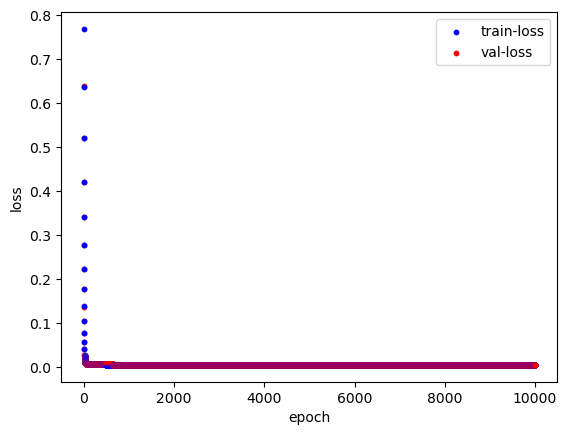

In [15]:
#%% Training
plt.figure() # monitor loss curve during training
# for loop over epochs
for epoch in range(num_epoch):
    # classical forward pass -> predict new output from train data
    Y_pred_train = net(X_train)
    # compute loss    
    loss_train = loss_func(Y_pred_train, Y_train)
    
    # Compute gradients
    optimizer.zero_grad()
    # Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call
    # Note that following the first .backward call, a second call is only possible after you have performed another forward pass.
    loss_train.backward()
    # perform a parameter update based on the current gradient (stored in .grad attribute of a parameter)
    optimizer.step()
    
    # TODO**
    # forward pass for validation
    Y_pred_val = net(X_val)
    loss_val = loss_func(Y_pred_val, Y_val)
    # TODO**
    
    # plot train and val loss
    plt.scatter(epoch, loss_train.data.item(), color='b', s=10, marker='o')    
    plt.scatter(epoch, loss_val.data.item(), color='r', s=10, marker='o')
    
    # print message with actual losses
    print('Train Epoch: {}/{} ({:.0f}%)\ttrain_Loss: {:.6f}\tval_Loss: {:.6f}'.format(
    epoch+1, num_epoch, epoch/num_epoch*100, loss_train.item(), loss_val.item()))


# show training and validation loss    
plt.legend(['train-loss','val-loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(path, 'results/who_loss.png'))
#plt.show()

print('Train loss before training was:', loss_train_before.item())
print('Train loss after training is:', loss_train.item())
print('Val loss before training was:', loss_val_before.item())
print('Val loss after training is:', loss_val.item())

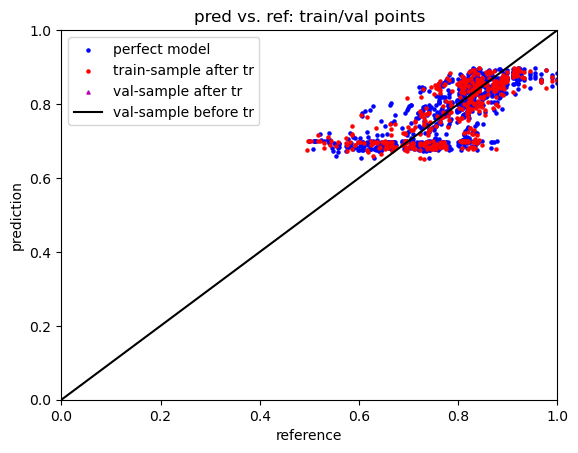

In [16]:
#%% Pred vs. Ref Figure Train/Val set
# plot the prediction against the reference for the train/val points
# if the prediction equals the reference the dots will appear at the 'perfect model' line
plt.figure()
plt.title('pred vs. ref: train/val points')
plt.scatter(Y_train.cpu().numpy(), Y_pred_train.cpu().detach().numpy(), color='b', s=5, marker='o')
plt.scatter(Y_val.cpu().numpy(), Y_pred_val.cpu().detach().numpy(), color='r', s=5, marker='o')
plt.scatter(Y_val.cpu().numpy(), Y_pred_val_before.cpu().detach().numpy(), color='m', s=5, marker='^')
plt.plot((0,1),(0,1), color='k')
plt.xlabel('reference')
plt.ylabel('prediction')
plt.legend(['perfect model', 'train-sample after tr','val-sample after tr', 'val-sample before tr'])
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig(os.path.join(path, 'results/who_pred_vs_ref_val.png'))

In [17]:
#%% Test results
# TODO**
# forward pass 
# Y_pred_test_oh is on the GPU, because net and X_test are on the GPU, but we want it on the CPU from now on.
Y_pred_test = 
loss_test = 
# TODO**
print('Test loss before training was:', loss_test_before.item())
print('Test loss after training is:', loss_test.item())

# Plot mean abs difference between prediction and reference
print('Mean abs difference:', np.mean(abs(Y_pred_test.cpu().detach().numpy()-Y_test.cpu().numpy()), axis=0)*scale_y, 'years')

SyntaxError: invalid syntax (1376436366.py, line 5)

In [ ]:
#%% Pred vs. Ref Figure Test set
# plot the prediction against the reference for the test points
# if the prediction equals the reference the dots will appear at the 'perfect model' line
plt.figure()
plt.title('pred vs. ref: test points')
plt.scatter(Y_test.cpu().numpy(), Y_pred_test.cpu().detach().numpy(), color='g', s=5, marker='o')
plt.scatter(Y_test.cpu().numpy(), Y_pred_test_before.cpu().detach().numpy(), color='m', s=5, marker='^')
plt.plot((0,1),(0,1), color='k')
plt.xlabel('reference')
plt.ylabel('prediction')
plt.legend(['perfect model','test-sample after tr', 'test-sample before tr'])
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig(os.path.join(path, 'results/who_pred_vs_ref_test.png'))